<a href="https://colab.research.google.com/github/kaleabendrias/data_sc/blob/main/Pneumonia_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
# to upload files
from google.colab import files

# install Kaggle library
!pip list
!pip install -q kaggle

Package                       Version
----------------------------- ---------------------
absl-py                       1.4.0
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
anyio                         3.6.2
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
array-record                  0.2.0
arviz                         0.15.1
astropy                       5.2.2
astunparse                    1.6.3
attrs                         23.1.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.12.1
backcall                      0.2.0
beautifulsoup4                4.11.2
bleach                        6.0.0
blis                          0.7.9
blosc2                        2.0.0
bokeh                         2.4.3
branca                        0.6.0
build                         0.10.0
CacheControl                  0.12.11
ca

In [71]:
# upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [72]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop

import requests
from io import BytesIO

import json
import zipfile

from random import sample
from datetime import datetime
from tqdm import tqdm, auto
import shutil
import os
import gc
import warnings
warnings.filterwarnings("ignore")

In [74]:
# download dataset <owner>/<dataset-name>
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:23<00:00, 45.7MB/s]
100% 2.29G/2.29G [00:23<00:00, 107MB/s] 


# New Section

In [75]:
with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zf:
  zf.extractall()

img_dir = os.path.join(os.getcwd(), 'chest_xray')
test_img_dir = os.path.join(img_dir, 'test')
train_img_dir = os.path.join(img_dir, 'train')
val_img_dir = os.path.join(img_dir, 'val')

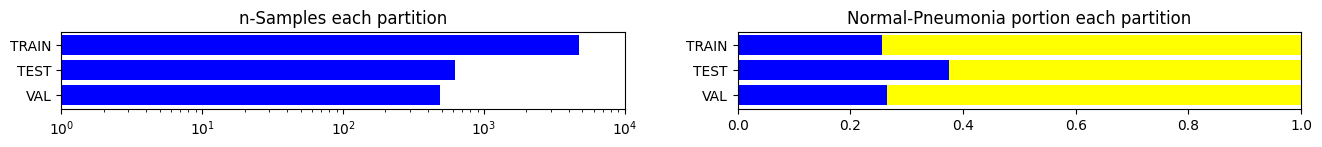

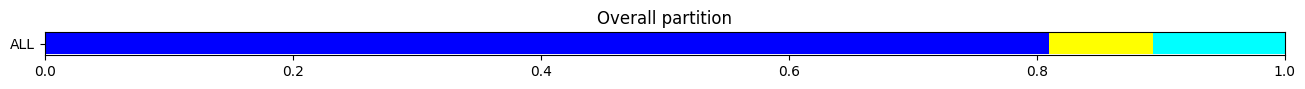

In [85]:
NB_TRAIN_SAMPLES_N = len(os.listdir(os.path.join(train_img_dir, 'NORMAL')))
NB_TRAIN_SAMPLES_P = len(os.listdir(os.path.join(train_img_dir, 'PNEUMONIA')))
NB_TRAIN_SAMPLES = NB_TRAIN_SAMPLES_N + NB_TRAIN_SAMPLES_P

NB_VAL_SAMPLES_N = len(os.listdir(os.path.join(val_img_dir, 'NORMAL')))
NB_VAL_SAMPLES_P = len(os.listdir(os.path.join(val_img_dir, 'PNEUMONIA')))
NB_VAL_SAMPLES = NB_VAL_SAMPLES_N + NB_VAL_SAMPLES_P

NB_TEST_SAMPLES_N = len(os.listdir(os.path.join(test_img_dir, 'NORMAL')))
NB_TEST_SAMPLES_P = len(os.listdir(os.path.join(test_img_dir, 'PNEUMONIA')))
NB_TEST_SAMPLES = NB_TEST_SAMPLES_N + NB_TEST_SAMPLES_P

NB_TOTAL_SAMPLES = NB_TRAIN_SAMPLES + NB_VAL_SAMPLES + NB_TEST_SAMPLES

def chart_partitioning():

  fig = plt.figure(figsize=(16,1))

  ax = fig.add_subplot(1,2,1)
  ax.barh(['VAL'], [NB_VAL_SAMPLES], color='#0000ff')
  ax.barh(['TEST'], [NB_TEST_SAMPLES], color='#0000ff')
  ax.barh(['TRAIN'], [NB_TRAIN_SAMPLES], color='#0000ff')
  ax.set_xscale('log')
  ax.set_xlim((1,1e4))
  ax.set_title('n-Samples each partition');

  ax = fig.add_subplot(1,2,2)
  ax.barh(['VAL'], [NB_VAL_SAMPLES_N/NB_VAL_SAMPLES], color='#0000ff')
  ax.barh(['VAL'], [NB_VAL_SAMPLES_P/NB_VAL_SAMPLES], color='#ffff00',
          left=[NB_VAL_SAMPLES_N/NB_VAL_SAMPLES])
  ax.barh(['TEST'], [NB_TEST_SAMPLES_N/NB_TEST_SAMPLES], color='#0000ff')
  ax.barh(['TEST'], [NB_TEST_SAMPLES_P/NB_TEST_SAMPLES], color='#ffff00',
          left=[NB_TEST_SAMPLES_N/NB_TEST_SAMPLES])
  ax.barh(['TRAIN'], [NB_TRAIN_SAMPLES_N/NB_TRAIN_SAMPLES], color='#0000ff')
  ax.barh(['TRAIN'], [NB_TRAIN_SAMPLES_P/NB_TRAIN_SAMPLES], color='#ffff00',
          left=[NB_TRAIN_SAMPLES_N/NB_TRAIN_SAMPLES])
  ax.set_xlim((0,1))
  ax.set_title('Normal-Pneumonia portion each partition');

  fig = plt.figure(figsize=(16,0.3))
  ax = fig.add_subplot(1,1,1)
  NB_TOTAL_SAMPLES = NB_TEST_SAMPLES + NB_TRAIN_SAMPLES + NB_VAL_SAMPLES
  ax.barh(['ALL'], [NB_TRAIN_SAMPLES/NB_TOTAL_SAMPLES], color='#0000ff')
  ax.barh(['ALL'], [NB_VAL_SAMPLES/NB_TOTAL_SAMPLES], color='#ffff00',
          left=[NB_TRAIN_SAMPLES/NB_TOTAL_SAMPLES])
  ax.barh(['ALL'], [NB_TEST_SAMPLES/NB_TOTAL_SAMPLES], color='#00ffff',
          left=[(NB_TRAIN_SAMPLES+NB_VAL_SAMPLES)/NB_TOTAL_SAMPLES])
  ax.set_xlim((0,1))
  ax.set_title('Overall partition');

chart_partitioning()





In [77]:
#This code segment is responsible for moving a specific number of files randomly from the training
#directory to the validation directory. The goal is to adjust the proportions of the samples between the training
#and validation sets so that the training set comprises approximately 80% of the total samples.

# count how many samples to move so that train partition ~80%
train_part = NB_TRAIN_SAMPLES/NB_TOTAL_SAMPLES
n_to_move = round((train_part - 0.8) * NB_TRAIN_SAMPLES)
# count each n and p samples to move
# later train val have the same N/P proportion
n_to_move_N = round((NB_TRAIN_SAMPLES_N + NB_VAL_SAMPLES_N) /
                    (NB_TRAIN_SAMPLES + NB_VAL_SAMPLES) * n_to_move)
n_to_move_P = n_to_move - n_to_move_N

# move rendom files from one directory to other directory
def move_files_random(from_dir, to_dir, n):
  for filename in sample(os.listdir(from_dir), k=n):
    from_fpath = os.path.join(from_dir, filename)
    to_fpath = os.path.join(to_dir, filename)
    shutil.move(from_fpath, to_fpath)
  display(f"move {n} files from {from_dir} to {to_dir}")

move_files_random(from_dir=os.path.join(train_img_dir, 'NORMAL'),
                  to_dir=os.path.join(val_img_dir, 'NORMAL'),
                  n=n_to_move_N)

move_files_random(from_dir=os.path.join(train_img_dir, 'PNEUMONIA'),
                  to_dir=os.path.join(val_img_dir, 'PNEUMONIA'),
                  n=n_to_move_P)

'move 122 files from /content/chest_xray/train/NORMAL to /content/chest_xray/val/NORMAL'

'move 351 files from /content/chest_xray/train/PNEUMONIA to /content/chest_xray/val/PNEUMONIA'

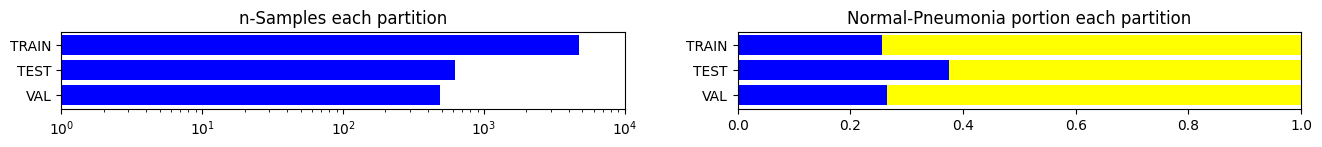

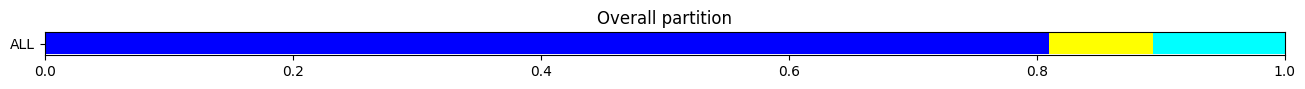

In [78]:
#@title samples partition after restructure { display-mode: "form" }

NB_TRAIN_SAMPLES_N = len(os.listdir(os.path.join(train_img_dir, 'NORMAL')))
NB_TRAIN_SAMPLES_P = len(os.listdir(os.path.join(train_img_dir, 'PNEUMONIA')))
NB_TRAIN_SAMPLES = NB_TRAIN_SAMPLES_N + NB_TRAIN_SAMPLES_P

NB_VAL_SAMPLES_N = len(os.listdir(os.path.join(val_img_dir, 'NORMAL')))
NB_VAL_SAMPLES_P = len(os.listdir(os.path.join(val_img_dir, 'PNEUMONIA')))
NB_VAL_SAMPLES = NB_VAL_SAMPLES_N + NB_VAL_SAMPLES_P

NB_TEST_SAMPLES_N = len(os.listdir(os.path.join(test_img_dir, 'NORMAL')))
NB_TEST_SAMPLES_P = len(os.listdir(os.path.join(test_img_dir, 'PNEUMONIA')))
NB_TEST_SAMPLES = NB_TEST_SAMPLES_N + NB_TEST_SAMPLES_P

NB_TOTAL_SAMPLES = NB_TRAIN_SAMPLES + NB_VAL_SAMPLES + NB_TEST_SAMPLES

chart_partitioning()

In [89]:
#@title set epoch, batch_size { display-mode: "form" }

EPOCHS = 25 #@param {type:"slider", min:5, max:30, step:1}
BATCH_SIZE =  100#@param {type:"number"}

In [90]:
IMG_WIDTH, IMG_HEIGHT = 150, 150

train_datagen = ImageDataGenerator(
                   rescale=1./255,
                   rotation_range=8,  # degrees
                   zoom_range=0.1,
                   width_shift_range=0.08,  # per cent width
                   height_shift_range=0.08,  # per cent height
                   horizontal_flip=False,
                   vertical_flip=False,
                   shear_range=0.02,
                   )

train_generator = train_datagen.flow_from_directory(
                                   train_img_dir,
                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                   batch_size=BATCH_SIZE,
                                   class_mode='binary',
                                   )

test_datagen = ImageDataGenerator(rescale=1./255)

val_generator = test_datagen.flow_from_directory(
                                val_img_dir,
                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                batch_size=BATCH_SIZE,
                                class_mode='binary',
                                )

test_generator = test_datagen.flow_from_directory(
                                test_img_dir,
                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                batch_size=32,
                                shuffle=False, # makes it useful when evaluating model
                                class_mode='binary',
                                )

Found 4743 images belonging to 2 classes.
Found 489 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


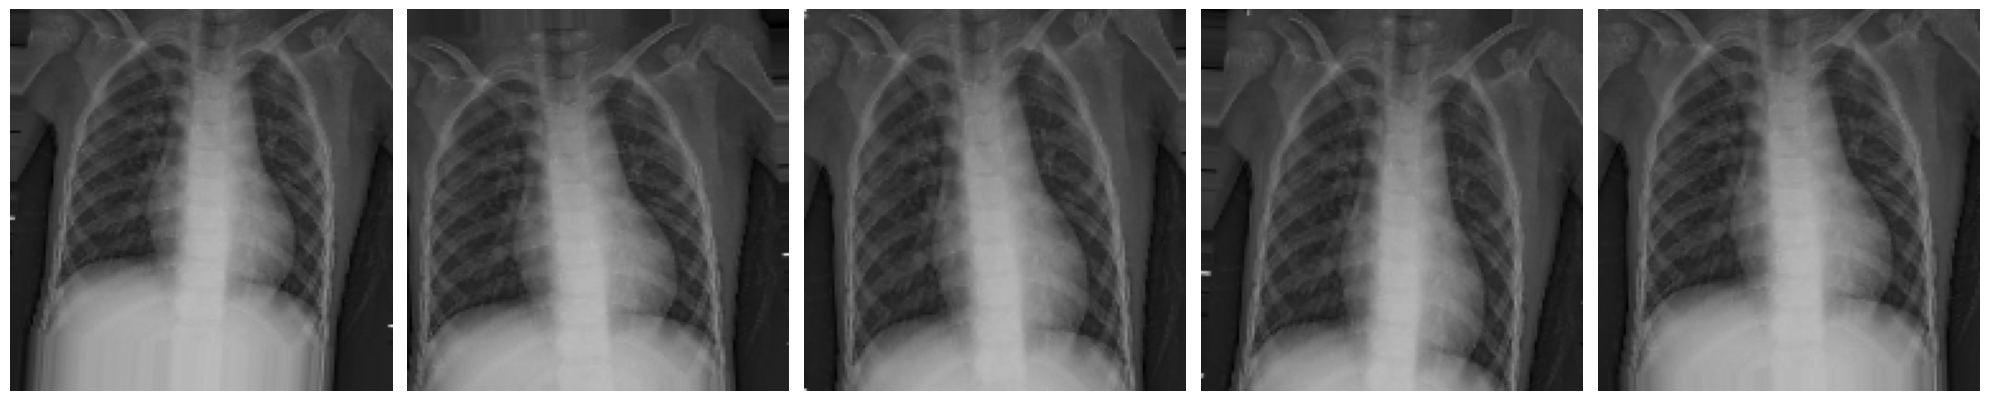

In [91]:
#@title check posibilities of augmented images at training dataset { display-mode: "form" }

flow_n = 1 #@param {type:"slider", min:0, max:10, step:1}
idx_m = 10 #@param {type:"slider", min:0, max:99, step:1}

# This function will plot augmented images
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20,20)) #creates a figure with 1 row and 5 columns, and sets the size of the figure to (20, 20)
  axes = axes.flatten() # flattens the axes array into a 1-dimensional array.
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout() # line adjusts the spacing between subplots
  plt.show();

plotImages([train_generator[flow_n][0][idx_m] for i in range(5)])

In [93]:
#@title set optimizer and learning_rate{ display-mode: "form" }

optimizer = "RMSprop" #@param ["adam", "RMSprop"]
learning_rate = 0.0008 #@param {type:"number"}

optimizer = Adam(learning_rate=learning_rate) if optimizer == "adam" \
              else RMSprop(learning_rate=learning_rate)

In [94]:
inputs = Input(shape = (IMG_WIDTH, IMG_HEIGHT, 3))
model = Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
               input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))(inputs)
model = MaxPooling2D(pool_size=(2, 2))(model)
model = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(model)
model = MaxPooling2D(pool_size=(2, 2))(model)
model = Flatten()(model)
model = Dense(activation='relu', units=128)(model)
outputs = Dense(activation='sigmoid', units=1)(model)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

loss = 'binary_crossentropy'
metrics = ['accuracy']

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 41472)             0   

In [95]:
gc.collect()

86802

In [ ]:
history = model.fit_generator(
                      train_generator,
                      steps_per_epoch=NB_TRAIN_SAMPLES//BATCH_SIZE+1,
                      epochs=EPOCHS,
                      validation_data=val_generator,
                      validation_steps=NB_VAL_SAMPLES//BATCH_SIZE+1,
                      # callbacks=,
                      )

Epoch 1/25
48/48 [==============================] - 254s 5s/step - loss: 0.7940 - accuracy: 0.7048 - val_loss: 0.4605 - val_accuracy: 0.7342
Epoch 2/25
16/48 [=========>....................] - ETA: 2:25 - loss: 0.5357 - accuracy: 0.7381